<a href="https://colab.research.google.com/github/Aya-Elgammal/predicting_mobile_game/blob/main/predicting_mobile_game.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
import pickle

In [40]:
df = pd.read_csv("/content/predicting_mobile_game_success_train_set.csv")
print("Dataset preview:")
print(df.head(), "\n")

Dataset preview:
                                                 URL         ID  \
0   https://apps.apple.com/us/app/sudoku/id284921427  284921427   
1  https://apps.apple.com/us/app/reversi/id284926400  284926400   
2  https://apps.apple.com/us/app/morocco/id284946595  284946595   
3  https://apps.apple.com/us/app/sudoku-free/id28...  285755462   
4  https://apps.apple.com/us/app/senet-deluxe/id2...  285831220   

            Name Subtitle                                           Icon URL  \
0         Sudoku      NaN  https://is2-ssl.mzstatic.com/image/thumb/Purpl...   
1        Reversi      NaN  https://is4-ssl.mzstatic.com/image/thumb/Purpl...   
2        Morocco      NaN  https://is5-ssl.mzstatic.com/image/thumb/Purpl...   
3  Sudoku (Free)      NaN  https://is3-ssl.mzstatic.com/image/thumb/Purpl...   
4   Senet Deluxe      NaN  https://is1-ssl.mzstatic.com/image/thumb/Purpl...   

   Average User Rating  User Rating Count  Price In-app Purchases  \
0                  4.0        

In [41]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13599 entries, 0 to 13598
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   URL                           13599 non-null  object 
 1   ID                            13599 non-null  int64  
 2   Name                          13599 non-null  object 
 3   Subtitle                      2828 non-null   object 
 4   Icon URL                      13599 non-null  object 
 5   Average User Rating           6518 non-null   float64
 6   User Rating Count             6518 non-null   float64
 7   Price                         13598 non-null  float64
 8   In-app Purchases              6351 non-null   object 
 9   Description                   13599 non-null  object 
 10  Developer                     13599 non-null  object 
 11  Age Rating                    13599 non-null  object 
 12  Languages                     13558 non-null  object 
 13  S

In [42]:
df["Size_MB"] = df["Size"] / (1024 * 1024)

In [43]:
df['In-app Purchases'] = df['In-app Purchases'].fillna("")
df['Num_InApp_Options'] = df['In-app Purchases'].apply(
    lambda x: len(str(x).split(',')) if str(x).strip() != "" else 0
)
df.drop('In-app Purchases', axis=1, inplace=True)

In [44]:
df['Age Rating'] = df['Age Rating'].str.replace('+', '', regex=False).astype(int)

In [45]:
df['Desc_Sentiment'] = df['Description'].apply(
    lambda x: TextBlob(x).sentiment.polarity
)

In [46]:
df['Desc_Sentiment'].describe()

,Desc_Sentiment
count,13599.000000
mean,0.125160
std,0.152378
min,-1.000000
25%,0.034893
50%,0.128571
75%,0.212529
max,1.000000


In [47]:
df[['Desc_Sentiment', 'Average User Rating']].corr()

,Desc_Sentiment,Average User Rating
Desc_Sentiment,1.000000,0.050027
Average User Rating,0.050027,1.000000


In [48]:
keywords = ['offline', 'multiplayer', 'puzzle', 'brain', 'kids', 'educational', 'ads', 'free']

for word in keywords:
    df[f'Has_{word}'] = df['Description'].str.contains(word, case=False).astype(int)
for word in keywords:
    print(word, df.groupby(f'Has_{word}')['Average User Rating'].mean())

offline Has_offline
0    4.025441
1    4.189956
Name: Average User Rating, dtype: float64
multiplayer Has_multiplayer
0    4.028761
1    4.053738
Name: Average User Rating, dtype: float64
puzzle Has_puzzle
0    4.010705
1    4.150000
Name: Average User Rating, dtype: float64
brain Has_brain
0    4.025020
1    4.136364
Name: Average User Rating, dtype: float64
kids Has_kids
0    4.032898
1    3.966667
Name: Average User Rating, dtype: float64
educational Has_educational
0    4.030951
1    4.075000
Name: Average User Rating, dtype: float64
ads Has_ads
0    4.032848
1    4.015523
Name: Average User Rating, dtype: float64
free Has_free
0    3.996330
1    4.095425
Name: Average User Rating, dtype: float64


In [49]:
df['Keyword_Count'] = df[[f'Has_{w}' for w in keywords]].sum(axis=1)
df['Keyword_Count']

,Keyword_Count
0,2
1,1
2,0
3,2
4,0
...,...
13594,3
13595,3
13596,1
13597,1


In [50]:
top_genres = df['Primary Genre'].value_counts().nlargest(5).index

df['Primary_Genre_'] = df['Primary Genre'].apply(
    lambda x: x if x in top_genres else 'Other'
)

In [51]:
df['Genre_Count'] = df['Genres'].apply(
    lambda x: len(str(x).split(','))
)

In [52]:

df['Genres'].str.split(',').explode().value_counts().head(10)

,count
Genres,
Strategy,13599
Games,13058
Entertainment,6570
Puzzle,3287
Simulation,1603
Action,1544
Board,1435
Casual,1278
Role Playing,923


In [53]:
important_genres = ['Puzzle', 'Action', 'Strategy', 'Education', 'Adventure']

for g in important_genres:
    df[f'Has_{g}'] = df['Genres'].str.contains(g, case=False).astype(int)


In [54]:
genre_mean = df.groupby('Primary_Genre_')['Average User Rating'].mean()

df['Primary_Genre_Mean_Rating'] = df['Primary_Genre_'].map(genre_mean)

In [55]:
df['Current Version Release Date'] = pd.to_datetime(
    df['Current Version Release Date'],
    errors='coerce',
    dayfirst=True
)
df['Current_Version_Age_Days'] = (
    pd.Timestamp.now() - df['Current Version Release Date']
).dt.days
df['Current_Version_Age_Days'] = df['Current_Version_Age_Days'].fillna(
    df['Current_Version_Age_Days'].median()
)
df.drop('Current Version Release Date', axis=1, inplace=True)

In [56]:
df['Original Release Date'] = pd.to_datetime(
    df['Original Release Date'],
    errors='coerce',
    dayfirst=True
)
df['App_Age_Days'] = (
    pd.Timestamp.now() - df['Original Release Date']
).dt.days
df['App_Age_Days'] = df['App_Age_Days'].fillna(
    df['App_Age_Days'].median()
)
df.drop('Original Release Date', axis=1, inplace=True)

In [57]:
df = df.dropna(subset=['Languages'])
df['Language_Count'] = df['Languages'].apply(
    lambda x: len(set([lang.strip() for lang in x.split(',')])))


In [58]:
df.drop(columns=['Description'], inplace=True)

In [59]:
df.dropna(subset=['Average User Rating'], inplace=True)

In [60]:
df['Dev_App_Count'] = df.groupby('Developer')['Developer'].transform('count')
df['Dev_App_Count']

,Dev_App_Count
0,9
1,1
2,2
3,9
4,1
...,...
13590,2
13592,1
13593,1
13596,1


In [61]:
df.drop(['URL', 'Icon URL', 'ID','Unnamed: 18'], axis=1, inplace=True)

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6502 entries, 0 to 13597
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Name                       6502 non-null   object 
 1   Subtitle                   1848 non-null   object 
 2   Average User Rating        6502 non-null   float64
 3   User Rating Count          6502 non-null   float64
 4   Price                      6502 non-null   float64
 5   Developer                  6502 non-null   object 
 6   Age Rating                 6502 non-null   int64  
 7   Languages                  6502 non-null   object 
 8   Size                       6502 non-null   int64  
 9   Primary Genre              6502 non-null   object 
 10  Genres                     6502 non-null   object 
 11  Size_MB                    6502 non-null   float64
 12  Num_InApp_Options          6502 non-null   int64  
 13  Desc_Sentiment             6502 non-null   float64
 

In [63]:
features = [
    'Num_InApp_Options',
    'Age Rating',
    'Desc_Sentiment',
    'Keyword_Count',
    'Genre_Count',
    'Primary_Genre_Mean_Rating',
    'Current_Version_Age_Days',
    'App_Age_Days',
    'Language_Count',
    'Dev_App_Count',

    'Has_offline', 'Has_multiplayer', 'Has_puzzle', 'Has_brain',
    'Has_kids', 'Has_educational', 'Has_ads', 'Has_free',
    'Has_Puzzle', 'Has_Action', 'Has_Strategy',
    'Has_Education', 'Has_Adventure'
]

X = df[features]
y = df['Average User Rating']

X = X.fillna(0)

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [65]:

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2:", r2_score(y_test, y_pred))

RMSE: 0.7224100161640835
R2: 0.07663078617614683


<Axes: xlabel='Average User Rating', ylabel='Count'>

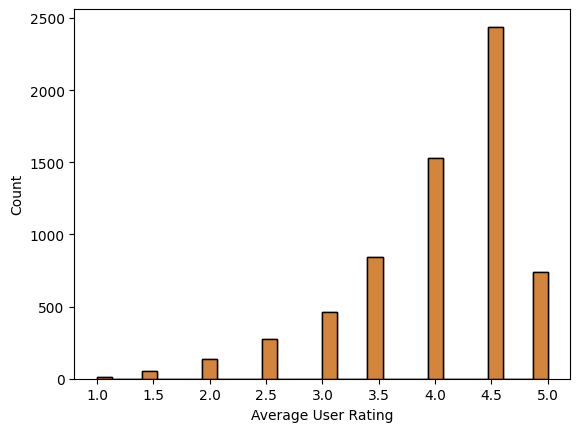

In [66]:
sns.histplot(df["Average User Rating"], bins=30)
import seaborn as sns
sns.histplot(df["Average User Rating"], bins=30)

In [67]:
df = df[(df["Average User Rating"] >= 3) &
        (df["Average User Rating"] <= 5)]

<Axes: xlabel='Average User Rating', ylabel='Count'>

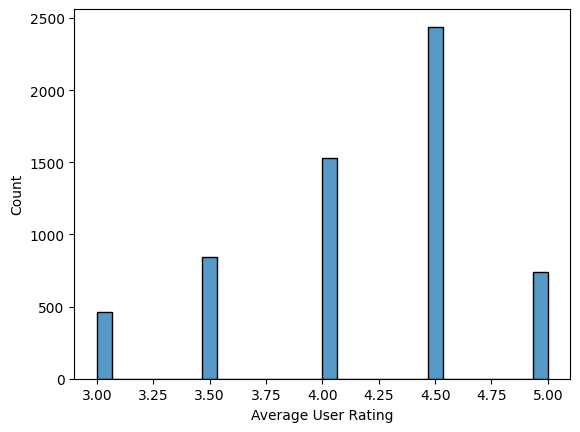

In [68]:
sns.histplot(df["Average User Rating"], bins=30)

In [69]:

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [70]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

model = Ridge(alpha=1.0)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2:", r2_score(y_test, y_pred))

RMSE: 0.7224067098917443
R2: 0.07663923817165097


In [71]:
X = df[features].values
y = df["Average User Rating"].values
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train = np.c_[np.ones((X_train.shape[0], 1)), X_train]
X_test = np.c_[np.ones((X_test.shape[0], 1)), X_test]
def gradient_descent(X, y, lr=0.02, n_iter=5000):
    m, n = X.shape
    theta = np.zeros(n)

    for _ in range(n_iter):
        predictions = X.dot(theta)
        errors = predictions - y
        gradients = (1/m) * X.T.dot(errors)
        theta = theta - lr * gradients

    return theta
theta = gradient_descent(X_train, y_train, lr=0.01, n_iter=2000)
y_pred = X_test.dot(theta)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("R2:", r2)
model_data = {
    "theta": theta,
    "scaler": scaler
}

with open("linear_model.pkl", "wb") as f:
    pickle.dump(model_data, f)

print("Model saved as linear_model.pkl")


RMSE: 0.5021321364097077
R2: 0.11692248271602823
Model saved as linear_model.pkl


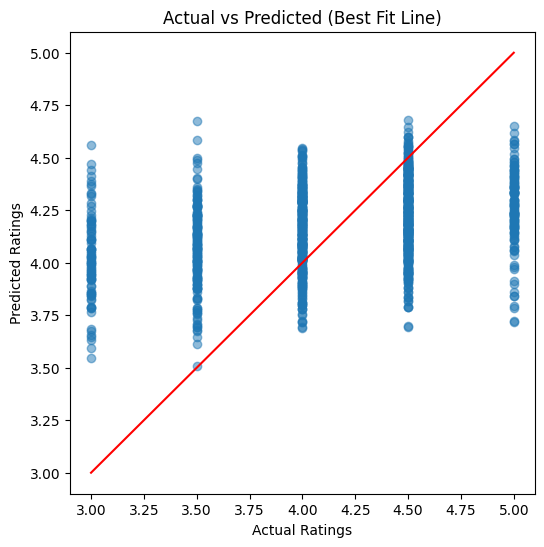

In [72]:
plt.figure(figsize=(6,6))

plt.scatter(y_test, y_pred, alpha=0.5)

min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())

plt.plot([min_val, max_val],
         [min_val, max_val],
         color='red')

plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Ratings")
plt.title("Actual vs Predicted (Best Fit Line)")
plt.show()

In [73]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
X_train_poly = np.c_[np.ones((X_train_poly.shape[0], 1)), X_train_poly]
X_test_poly = np.c_[np.ones((X_test_poly.shape[0], 1)), X_test_poly]
def gradient_descent(X, y, lr=0.01, n_iter=5000):
    m, n = X.shape
    theta = np.zeros(n)

    for _ in range(n_iter):
        predictions = X.dot(theta)
        errors = predictions - y
        gradients = (1/m) * X.T.dot(errors)
        theta -= lr * gradients

    return theta
theta = gradient_descent(
    X_train_poly,
    y_train,
    lr=0.001,
    n_iter=8000
)
y_pred = X_test_poly.dot(theta)


rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("R2:", r2)


RMSE: 0.511420853422503
R2: 0.08394898751559043
